In [1]:
import numpy as np

import pandas as pd

import scipy
import scipy.sparse as sp

import tensorflow as tf

class SequenceEncoder :
    
    def __init__(self, encoder_type_id, encode_dims) :
        self.encoder_type_id = encoder_type_id
        self.encode_dims = encode_dims
    
    def encode(self, seq) :
        raise NotImplementedError()
    
    def encode_inplace(self, seq, encoding) :
        raise NotImplementedError()
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementedError()
    
    def decode(self, encoding) :
        raise NotImplementedError()
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementedError()
    
    def __call__(self, seq) :
        return self.encode(seq)
    
class OneHotEncoder(SequenceEncoder) :
    
    def __init__(self, seq_length, channel_map) :
        super(OneHotEncoder, self).__init__('onehot', (seq_length, len(channel_map)))
        
        self.seq_len = seq_length
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            val : key for key, val in channel_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            if max_nt == 1 :
                seq += self.decode_map[argmax_nt]
            else :
                seq += self.decode_map[self.n_channels - 1]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        encoding = np.array(encoding_mat[row_index, :].todense()).reshape(-1, 4)
        return self.decode(encoding)

#Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [2]:

df = pd.read_csv("apadb_processed_v2_utr3_isoforms.csv", sep='\t')


In [3]:

df


,gene_id,seq
0,A1BG.1,TGATGCAGCCGCGGGCCCAGGGTGCTGTTGGTGTCCTCAGAAGTGC...
1,A1CF.1,TGAAGATGCTTTTTTAAATTTAAGAATAAGACACACAAAACTCTAT...
2,A1CF.2,TGAAGATGCTTTTTTAAATTTAAGAATAAGACACACAAAACTCTAT...
3,A2M.1,TGAAGACCACAAGGCTGAAAAGTGCTTTGCTGGAGTCCTGTTCTCA...
4,A2M.2,TGAAGACCACAAGGCTGAAAAGTGCTTTGCTGGAGTCCTGTTCTCA...
...,...,...
44187,ZZZ3.2,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...
44188,ZZZ3.3,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...
44189,ZZZ3.4,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...
44190,ZZZ3.5,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...


In [4]:
#From Sabeti_testSet/pmirGLO_construct.txt

utr5 = "GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCGGCCAATAGCAGCTTTGCTCCTTCGCTTTCTGGGCTCAGAGGCTGGGAAGGGGTGGGTCCGGGGGCGGGCTCAGGGGCGGGCTCAGGGGCGGGGCGGGCGCCCGAAGGTCCTCCGGAGGCCCGGCATTCTGCACGCTTCAAAAGCGCACGTCTGCCGCGCTGTTCTCCTCTTCCTCATCTCCGGGCCTTTCGACCTGCAGCCCAAGCTTGGCAATCCGGTACTGTTGGTAAAGCCACC"
orf = "ATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCTTCACCTACGGCGTGCAGTGCTTCGCCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAAGGTCTATATCACCGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGACCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTAA"

print("len(utr5) = " + str(len(utr5)))
print("len(orf) = " + str(len(orf)))

df['full_seq'] = utr5 + orf + df['seq'].str.slice(3)


len(utr5) = 283
len(orf) = 720


In [5]:
df

,gene_id,seq,full_seq
0,A1BG.1,TGATGCAGCCGCGGGCCCAGGGTGCTGTTGGTGTCCTCAGAAGTGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
1,A1CF.1,TGAAGATGCTTTTTTAAATTTAAGAATAAGACACACAAAACTCTAT...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
2,A1CF.2,TGAAGATGCTTTTTTAAATTTAAGAATAAGACACACAAAACTCTAT...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
3,A2M.1,TGAAGACCACAAGGCTGAAAAGTGCTTTGCTGGAGTCCTGTTCTCA...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
4,A2M.2,TGAAGACCACAAGGCTGAAAAGTGCTTTGCTGGAGTCCTGTTCTCA...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
...,...,...,...
44187,ZZZ3.2,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
44188,ZZZ3.3,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
44189,ZZZ3.4,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...
44190,ZZZ3.5,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...


In [15]:

#!wget https://zenodo.org/record/6326409/files/datasets.zip?download=1


--2022-04-02 22:38:48--  https://zenodo.org/record/6326409/files/datasets.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18751132386 (17G) [application/octet-stream]
Saving to: ‘datasets.zip?download=1’

datasets.zip?downlo 100%[===================>]  17.46G  7.88MB/s    in 30m 35s 

2022-04-02 23:09:25 (9.74 MB/s) - ‘datasets.zip?download=1’ saved [18751132386/18751132386]



In [11]:

#!unzip ./datasets.zip "datasets/deeplearning/train_gru/params.json" -d "./"
'''
for f in range(10) :
    for c in range(5) :
        !unzip ./datasets.zip "datasets/deeplearning/train_gru/f{f}_c{c}/train/model0_best.h5" -d "./"
'''

Archive:  ./datasets.zip
  inflating: ./datasets/deeplearning/train_gru/params.json  


'\nfor f in range(10) :\n    for c in range(5) :\n        !unzip ./datasets.zip "datasets/deeplearning/train_gru/f{f}_c{c}/train/model0_best.h5" -d "./"\n'

In [6]:
import os, sys
import argparse, json, h5py, time

from basenji import dna_io

try:
    import rnann
except:
    from basenji import rnann

encode_batch_size = 4800
predict_batch_size = 64
MAXLEN = 12288

params_file = "datasets/deeplearning/train_gru/params.json"

# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_model = params['model']
params_train = params['train']

aa_len = int(len(orf)/3)
coding = np.append(np.zeros(len(utr5)), np.tile([1,0,0], aa_len))

seqs = df['full_seq'].values.tolist()

batch_remainder = (encode_batch_size - len(seqs) % encode_batch_size) if len(seqs) % encode_batch_size > 0 else 0

seqs.extend([df.iloc[-1]['full_seq'] for i in range(batch_remainder)])

n_batches = len(seqs) // encode_batch_size

print("n_batches = " + str(n_batches))

#One-hot encode and predict mini-batches

for f in range(10) :
    for c in range(5) :

        print('f' + str(f) + '_c' + str(c))
        
        model_file = "datasets/deeplearning/train_gru/f" + str(f) + "_c" + str(c) + "/train/model0_best.h5"

        # initialize model
        seqnn_model = rnann.RnaNN(params_model)
        seqnn_model.restore(model_file)
        
        preds = []
        for batch_ix in range(n_batches) :

            if batch_ix % 1 == 0 : 
                print("batch_ix = " + str(batch_ix))

            batch = np.zeros((encode_batch_size,MAXLEN,6))

            for i, myseq in enumerate(seqs[batch_ix*encode_batch_size:(batch_ix+1)*encode_batch_size]) :
                batch[i,0:len(myseq),0:4] = dna_io.dna_1hot(myseq)
                batch[i,0:len(coding),4] = coding

            pred = seqnn_model.predict(batch, batch_size=predict_batch_size)

            preds.append(pred)

        preds = np.concatenate(preds, axis=0)[:len(df), 0]

        df['isoform_hl_f' + str(f) + '_c' + str(c)] = preds


n_batches = 10
f0_c0
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift (Stochastic (None, 12288, 6)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization (LayerNo (None, 12284, 64)         128       
_________________________________________________________________
re_lu (ReLU)                 (None, 12284, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12280, 64)         20544     
_________________________________________________________________
dropout (Dropout)            (None, 1228

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f0_c2
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_2 (Stochast (None, 12288, 6)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_14 (Laye (None, 12284, 64)         128       
_________________________________________________________________
re_lu_18 (ReLU)              (None, 12284, 64)         0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 12280, 64)         20544     
__

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f0_c4
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_4 (Stochast (None, 12288, 6)          0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_28 (Laye (None, 12284, 64)         128       
_________________________________________________________________
re_lu_36 (ReLU)              (None, 12284, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 12280, 64)         20544     
__

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f1_c1
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_6 (Stochast (None, 12288, 6)          0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_42 (Laye (None, 12284, 64)         128       
_________________________________________________________________
re_lu_54 (ReLU)              (None, 12284, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 12280, 64)         20544     
_

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f1_c4
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_9 (Stochast (None, 12288, 6)          0         
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_63 (Laye (None, 12284, 64)         128       
_________________________________________________________________
re_lu_81 (ReLU)              (None, 12284, 64)         0         
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 12280, 64)         20544     
_

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f2_c1
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_11 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_77 (Laye (None, 12284, 64)         128       
_________________________________________________________________
re_lu_99 (ReLU)              (None, 12284, 64)         0         
_________________________________________________________________
conv1d_78 (Conv1D)           (None, 12280, 64)         20544     
_

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f2_c3
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_13 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_91 (Laye (None, 12284, 64)         128       
_________________________________________________________________
re_lu_117 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 12280, 64)         20544     
_

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f3_c0
Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_15 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_105 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_105 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_135 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_106 (Conv1D)          (None, 12280, 64)         20544     
_

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f3_c2
Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_17 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_119 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_119 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_153 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_120 (Conv1D)          (None, 12280, 64)         20544     
_

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f3_c4
Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_19 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_133 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_171 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 12280, 64)         20544     
_

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f4_c1
Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_21 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_147 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_147 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_189 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_148 (Conv1D)          (None, 12280, 64)         20544     
_

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f4_c3
Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_23 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_161 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_161 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_207 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_162 (Conv1D)          (None, 12280, 64)         20544     
_

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f5_c0
Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_25 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_175 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_175 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_225 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_176 (Conv1D)          (None, 12280, 64)         20544     
_

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f5_c2
Model: "model_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_27 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_189 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_189 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_243 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_190 (Conv1D)          (None, 12280, 64)         20544     
_

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f5_c4
Model: "model_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_29 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_203 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_203 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_261 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_204 (Conv1D)          (None, 12280, 64)         20544     
_

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f6_c1
Model: "model_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_31 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_217 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_217 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_279 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_218 (Conv1D)          (None, 12280, 64)         20544     
_

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f6_c3
Model: "model_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_33 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_231 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_231 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_297 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_232 (Conv1D)          (None, 12280, 64)         20544     
_

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f7_c0
Model: "model_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_35 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_245 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_245 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_315 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_246 (Conv1D)          (None, 12280, 64)         20544     
_

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f7_c2
Model: "model_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_37 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_259 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_259 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_333 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_260 (Conv1D)          (None, 12280, 64)         20544     
_

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f7_c4
Model: "model_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_39 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_273 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_273 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_351 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_274 (Conv1D)          (None, 12280, 64)         20544     
_

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f8_c1
Model: "model_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_41 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_287 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_287 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_369 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_288 (Conv1D)          (None, 12280, 64)         20544     
_

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f8_c3
Model: "model_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_43 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_301 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_301 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_387 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_302 (Conv1D)          (None, 12280, 64)         20544     
_

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f9_c0
Model: "model_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_45 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_315 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_315 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_405 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_316 (Conv1D)          (None, 12280, 64)         20544     
_

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f9_c2
Model: "model_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_47 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_329 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_329 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_423 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_330 (Conv1D)          (None, 12280, 64)         20544     
_

batch_ix = 1
batch_ix = 2
batch_ix = 3
batch_ix = 4
batch_ix = 5
batch_ix = 6
batch_ix = 7
batch_ix = 8
batch_ix = 9
f9_c4
Model: "model_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift_49 (Stochas (None, 12288, 6)          0         
_________________________________________________________________
conv1d_343 (Conv1D)          (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization_343 (Lay (None, 12284, 64)         128       
_________________________________________________________________
re_lu_441 (ReLU)             (None, 12284, 64)         0         
_________________________________________________________________
conv1d_344 (Conv1D)          (None, 12280, 64)         20544     
_

In [7]:
df

,gene_id,seq,full_seq,isoform_hl_f0_c0,isoform_hl_f0_c1,isoform_hl_f0_c2,isoform_hl_f0_c3,isoform_hl_f0_c4,isoform_hl_f1_c0,isoform_hl_f1_c1,...,isoform_hl_f8_c0,isoform_hl_f8_c1,isoform_hl_f8_c2,isoform_hl_f8_c3,isoform_hl_f8_c4,isoform_hl_f9_c0,isoform_hl_f9_c1,isoform_hl_f9_c2,isoform_hl_f9_c3,isoform_hl_f9_c4
0,A1BG.1,TGATGCAGCCGCGGGCCCAGGGTGCTGTTGGTGTCCTCAGAAGTGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,0.745317,-0.811233,-0.217996,0.035198,-0.209121,-0.124787,0.052781,...,-0.163416,-0.411486,0.098538,0.261979,0.188597,-1.084290,-0.817406,-0.471232,-0.791299,-0.505444
1,A1CF.1,TGAAGATGCTTTTTTAAATTTAAGAATAAGACACACAAAACTCTAT...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,1.149781,-0.034136,0.219740,0.733627,-0.127053,0.279444,0.412326,...,-0.231138,-0.086971,0.516204,0.671246,0.387870,-0.171109,0.021947,0.086684,-0.324672,-0.078090
2,A1CF.2,TGAAGATGCTTTTTTAAATTTAAGAATAAGACACACAAAACTCTAT...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,1.279510,-0.145394,0.431081,0.584265,0.049615,0.369911,0.575223,...,0.472272,0.132261,0.555072,0.927459,0.961914,-0.575846,0.024511,0.263753,-0.208599,0.120312
3,A2M.1,TGAAGACCACAAGGCTGAAAAGTGCTTTGCTGGAGTCCTGTTCTCA...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,0.761768,-0.949961,-0.043683,0.019976,-0.245927,-0.387083,-0.214954,...,-0.089624,-0.370891,-0.162451,-0.236939,-0.216497,-1.045459,-0.837175,-0.324617,-1.013405,-0.300716
4,A2M.2,TGAAGACCACAAGGCTGAAAAGTGCTTTGCTGGAGTCCTGTTCTCA...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,0.741909,-1.042630,-0.262034,-0.143220,-0.282205,-0.395402,-0.088607,...,-0.108728,-0.311336,-0.140303,-0.387356,0.312805,-0.979094,-0.742215,-0.332010,-1.010805,-0.427016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44187,ZZZ3.2,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,0.310752,-1.297050,-1.329757,-0.150477,-0.940907,-0.887008,-0.651291,...,-0.893317,-1.511418,-0.090253,-0.300338,-0.912440,-1.247144,-1.067717,-0.856836,-1.768156,-0.975687
44188,ZZZ3.3,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,0.394105,-1.266381,-1.240536,-0.057353,-0.932532,-0.837031,-0.594674,...,-0.831721,-1.487562,-0.094547,-0.242701,-0.839225,-1.219004,-0.910851,-0.804996,-1.739976,-0.950237
44189,ZZZ3.4,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,0.038308,-1.409010,-1.279967,-0.261359,-1.166120,-1.207635,-0.781358,...,-1.090454,-1.614188,-0.207833,-0.360971,-0.967107,-1.495389,-1.244539,-0.776860,-1.958706,-1.115671
44190,ZZZ3.5,TGACATGGAAGAGAACATCATTTACTAGTCCTCTTCAACACATAGC...,GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCG...,0.450250,-1.094120,-1.023590,0.011229,-0.704389,-0.792351,-0.535396,...,-0.527447,-1.119088,-0.123088,-0.096668,-0.501696,-1.249902,-0.898916,-0.608653,-1.861616,-0.887354


In [10]:

#df.drop(columns=['seq', 'full_seq']).to_csv("apadb_processed_v2_utr3_isoforms_saluki_pred_pmirGLO_construct.csv", sep='\t')
df = pd.read_csv("apadb_processed_v2_utr3_isoforms_saluki_pred_pmirGLO_construct.csv", sep='\t')


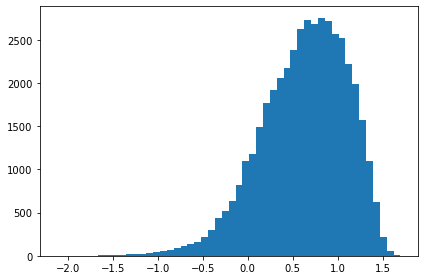

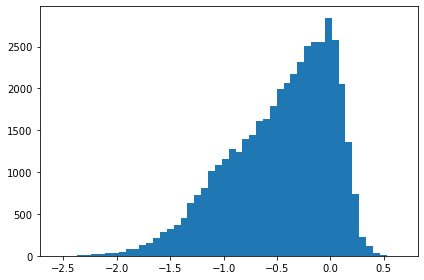

In [12]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(6, 4))

plt.hist(df['isoform_hl_f0_c0'].values, bins=50)

plt.tight_layout()

plt.show()

f = plt.figure(figsize=(6, 4))

plt.hist(df['isoform_hl_f0_c4'].values, bins=50)

plt.tight_layout()

plt.show()
